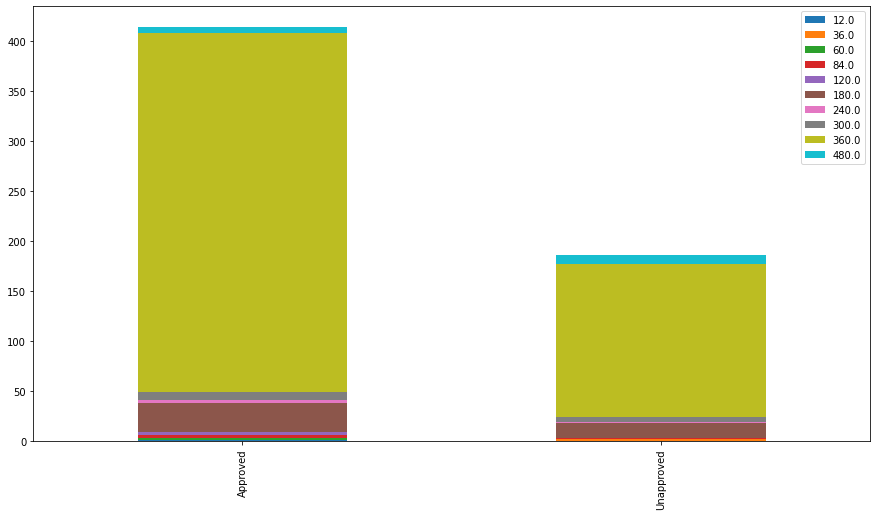

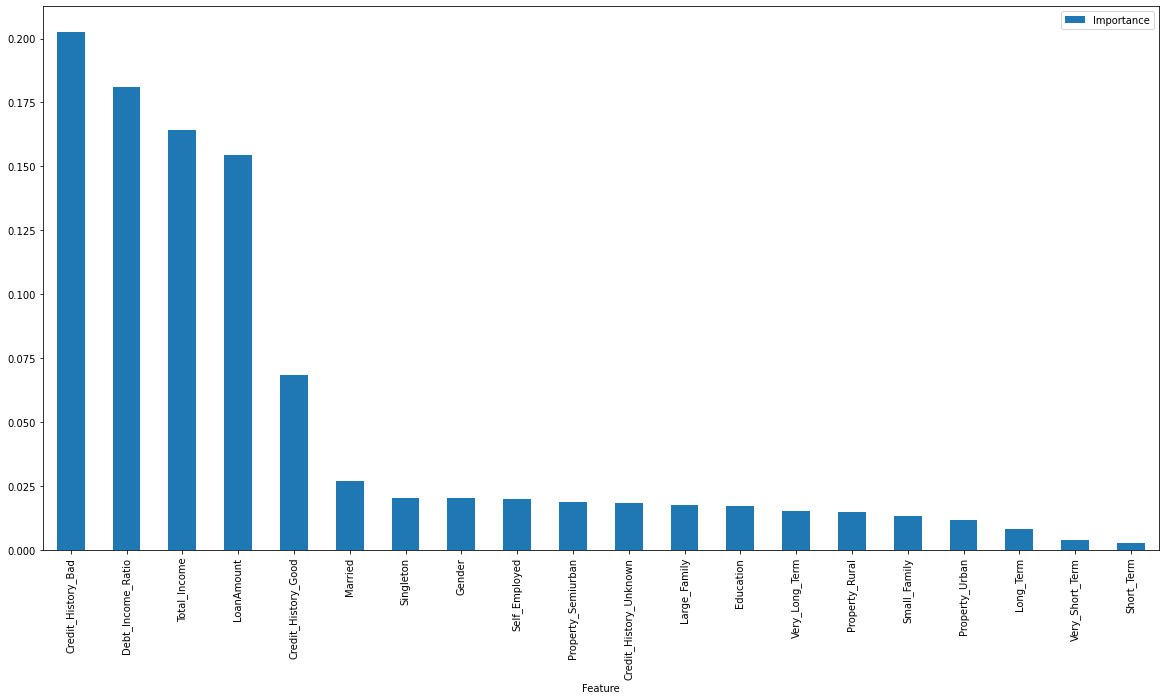

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:


data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')


# In[3]:


data_train.describe()


# In[4]:


data_train.isnull().sum()


# In[5]:



data_test.isnull().sum()


# In[6]:


data_train['Gender'].value_counts()


# In[7]:



data_test['Gender'].value_counts()


# In[8]:


def get_combined_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    targets = train.Loan_Status
    train.drop('Loan_Status', 1, inplace=True)
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Loan_ID'], inplace=True, axis=1)
    return combined


# In[9]:



combined = get_combined_data()
combined.describe()


# In[10]:


def impute_gender():
    global combined
    combined['Gender'].fillna('Male', inplace=True)


# In[11]:



def impute_martial_status():
    global combined
    combined['Married'].fillna('Yes', inplace=True)


# In[12]:


def impute_employment():
    global combined
    combined['Self_Employed'].fillna('No', inplace=True)


# In[13]:


def impute_loan_amount():
    global combined
    combined['LoanAmount'].fillna(combined['LoanAmount'].median(), inplace=True)


# In[14]:



def impute_credit_history():
    global combined
    combined['Credit_History'].fillna(2, inplace=True)


# In[15]:



combined['Credit_History'].value_counts()


# In[16]:



impute_gender()


# In[17]:


impute_martial_status()


# In[18]:



impute_employment()


# In[19]:


impute_loan_amount()


# In[20]:



impute_credit_history()


# In[21]:



combined.isnull().sum()


# In[22]:


def process_gender():
    global combined
    combined['Gender'] = combined['Gender'].map({'Male':1,'Female':0})


# In[23]:


def process_martial_status():
    global combined
    combined['Married'] = combined['Married'].map({'Yes':1,'No':0})


# In[24]:



def process_dependents():
    global combined
    combined['Singleton'] = combined['Dependents'].map(lambda d: 1 if d=='1' else 0)
    combined['Small_Family'] = combined['Dependents'].map(lambda d: 1 if d=='2' else 0)
    combined['Large_Family'] = combined['Dependents'].map(lambda d: 1 if d=='3+' else 0)
    combined.drop(['Dependents'], axis=1, inplace=True)


# In[25]:


def process_education():
    global combined
    combined['Education'] = combined['Education'].map({'Graduate':1,'Not Graduate':0})


# In[26]:



def process_employment():
    global combined
    combined['Self_Employed'] = combined['Self_Employed'].map({'Yes':1,'No':0})


# In[27]:


def process_income():
    global combined
    combined['Total_Income'] = combined['ApplicantIncome'] + combined['CoapplicantIncome']
    combined.drop(['ApplicantIncome','CoapplicantIncome'], axis=1, inplace=True)


# In[28]:



def process_loan_amount():
    global combined
    combined['Debt_Income_Ratio'] = combined['Total_Income'] / combined['LoanAmount']


# In[29]:


combined['Loan_Amount_Term'].value_counts()


# In[30]:


approved_term = data_train[data_train['Loan_Status']=='Y']['Loan_Amount_Term'].value_counts()
unapproved_term = data_train[data_train['Loan_Status']=='N']['Loan_Amount_Term'].value_counts()
df = pd.DataFrame([approved_term,unapproved_term])
df.index = ['Approved','Unapproved']
df.plot(kind='bar', stacked=True, figsize=(15,8))


# In[31]:


def process_loan_term():
    global combined
    combined['Very_Short_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t<=60 else 0)
    combined['Short_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>60 and t<180 else 0)
    combined['Long_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>=180 and t<=300  else 0)
    combined['Very_Long_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>300 else 0)
    combined.drop('Loan_Amount_Term', axis=1, inplace=True)


# In[32]:


def process_credit_history():
    global combined
    combined['Credit_History_Bad'] = combined['Credit_History'].map(lambda c: 1 if c==0 else 0)
    combined['Credit_History_Good'] = combined['Credit_History'].map(lambda c: 1 if c==1 else 0)
    combined['Credit_History_Unknown'] = combined['Credit_History'].map(lambda c: 1 if c==2 else 0)
    combined.drop('Credit_History', axis=1, inplace=True)


# In[33]:


def process_property():
    global combined
    property_dummies = pd.get_dummies(combined['Property_Area'], prefix='Property')
    combined = pd.concat([combined, property_dummies], axis=1)
    combined.drop('Property_Area', axis=1, inplace=True)


# In[34]:



process_gender()


# In[35]:


process_martial_status()


# In[36]:



process_dependents()


# In[37]:



process_education()


# In[38]:


process_employment()


# In[39]:


process_income()


# In[40]:


process_loan_amount()


# In[41]:


process_loan_term()


# In[42]:


process_credit_history()


# In[43]:


process_property()


# In[44]:


combined[60:70]


# In[45]:


def feature_scaling(df):
    df -= df.min()
    df /= df.max()
    return df


# In[46]:


combined['LoanAmount'] = feature_scaling(combined['LoanAmount'])
combined['Total_Income'] = feature_scaling(combined['Total_Income'])
combined['Debt_Income_Ratio'] = feature_scaling(combined['Debt_Income_Ratio'])


# In[47]:


combined[200:210]


# In[48]:



from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


# In[49]:


def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)


# In[50]:


def recover_train_test_target():
    global combined, data_train
    targets = data_train['Loan_Status'].map({'Y':1,'N':0})
    train = combined.head(614)
    test = combined.iloc[614:]
    return train, test, targets


# In[51]:


train, test, targets = recover_train_test_target()


# In[52]:


clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)


# In[53]:



features = pd.DataFrame()
features['Feature'] = train.columns
features['Importance'] = clf.feature_importances_
features.sort_values(by=['Importance'], ascending=False, inplace=True)
features.set_index('Feature', inplace=True)


# In[54]:


features.plot(kind='bar', figsize=(20, 10))


# In[55]:


model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
train_reduced.shape


# In[56]:


test_reduced = model.transform(test)
test_reduced.shape


# In[57]:


parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6}

model = RandomForestClassifier(**parameters)
model.fit(train, targets)


# In[58]:


compute_score(model, train, targets, scoring='accuracy')


# In[59]:


output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['Loan_ID'] = aux['Loan_ID']
df_output['Loan_Status'] = np.vectorize(lambda s: 'Y' if s==1 else 'N')(output)
df_output[['Loan_ID','Loan_Status']].to_csv('output.csv',index=False)


# In[ ]:




